# Unzipping Training and test set

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/train.csv.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/test.csv.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Toxic Comment Classification

This notebook provides a comprehensive solution to classify Wikipedia comments into different types of toxicity.

## Step 1: Import Libraries and Load Data


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint

# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    return text

# Apply preprocessing
train['comment_text'] = train['comment_text'].apply(preprocess_text)
test['comment_text'] = test['comment_text'].apply(preprocess_text)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['comment_text'])

train_sequences = tokenizer.texts_to_sequences(train['comment_text'])
test_sequences = tokenizer.texts_to_sequences(test['comment_text'])

max_seq_length = max([len(seq) for seq in train_sequences])

train_data = pad_sequences(train_sequences, maxlen=max_seq_length)
test_data = pad_sequences(test_sequences, maxlen=max_seq_length)


# EDA

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

# Target Distribution

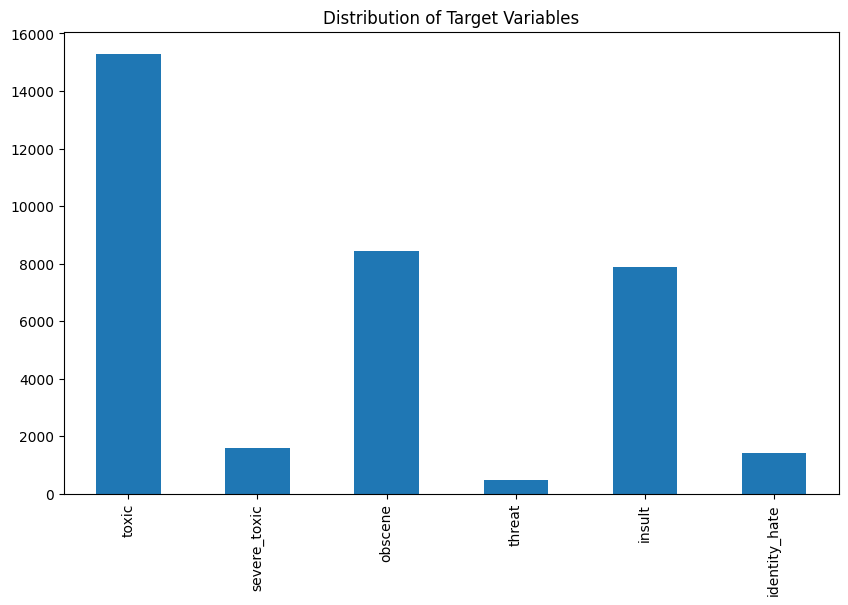

In [ ]:
# Cell 4: Target Distribution
targets = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train[targets].sum().plot(kind='bar', figsize=(10, 6), title='Distribution of Target Variables')
plt.show()

# Correlation Matrix

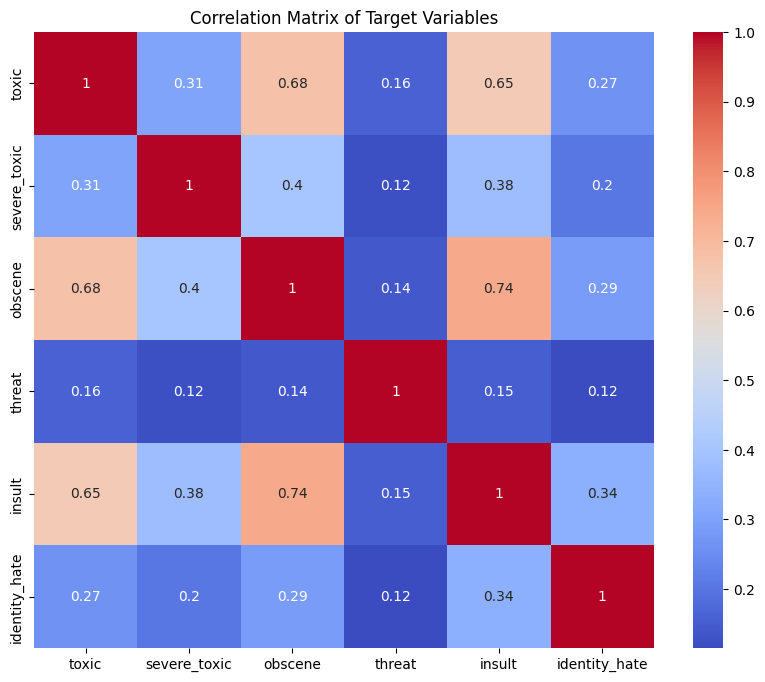

In [ ]:
# Cell 5: Correlation Matrix
corr_matrix = train[targets].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Target Variables')
plt.show()


# Text Length Distribution

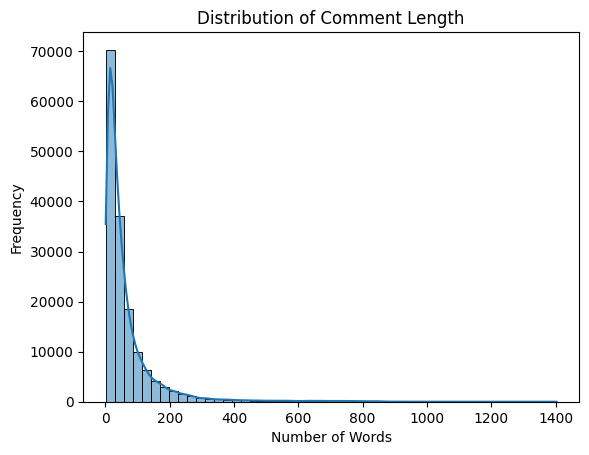

In [ ]:
# Cell 6: Text Length Distribution
train['comment_length'] = train['comment_text'].apply(lambda x: len(x.split()))
sns.histplot(train['comment_length'], bins=50, kde=True)
plt.title('Distribution of Comment Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


# Word Cloud for Toxic Comments

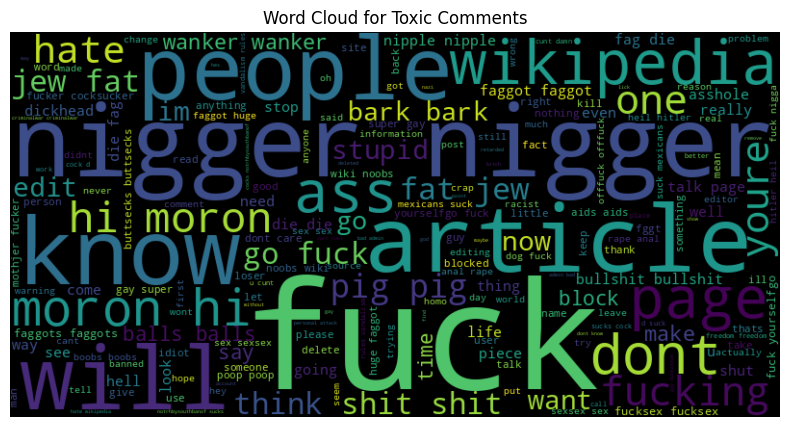

In [ ]:
# Cell 7: Word Cloud for Toxic Comments
toxic_comments = ' '.join(train[train['toxic'] == 1]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(toxic_comments)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()


# Word Cloud for Non-Toxic Comments

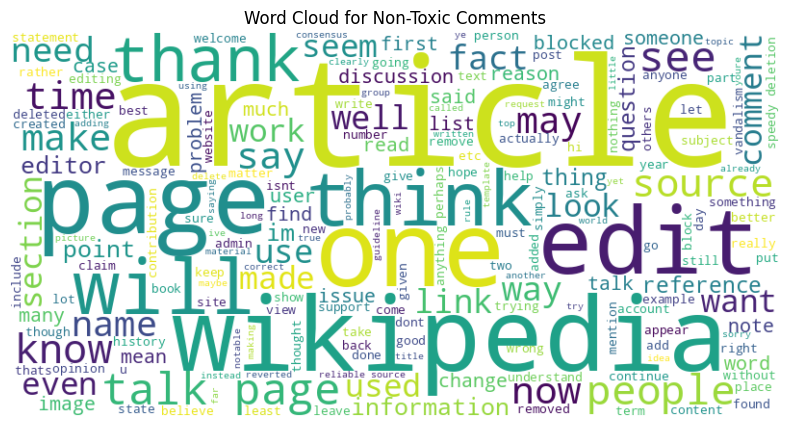

In [ ]:
# Cell 8: Word Cloud for Non-Toxic Comments
non_toxic_comments = ' '.join(train[train['toxic'] == 0]['comment_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_toxic_comments)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Toxic Comments')
plt.show()


# Most Common Words in Toxic Comments

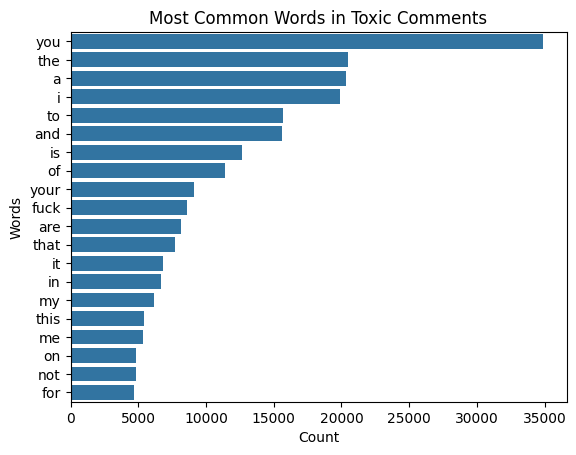

In [ ]:
# Cell 9: Most Common Words in Toxic Comments
from collections import Counter

toxic_words = ' '.join(train[train['toxic'] == 1]['comment_text']).split()
counter = Counter(toxic_words)
common_toxic_words = counter.most_common(20)
common_toxic_words_df = pd.DataFrame(common_toxic_words, columns=['word', 'count'])

sns.barplot(x='count', y='word', data=common_toxic_words_df)
plt.title('Most Common Words in Toxic Comments')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()


# Most Common Words in Non-Toxic Comments

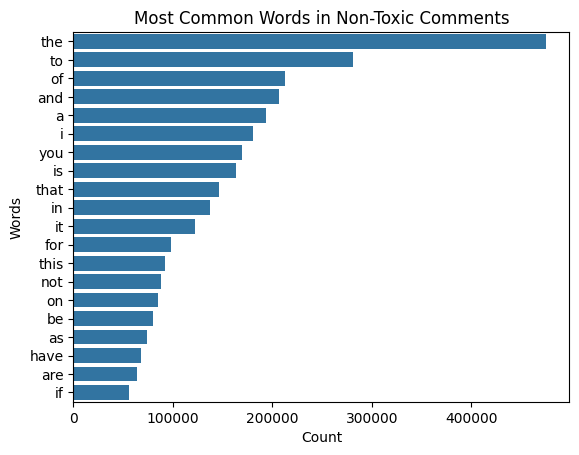

In [ ]:
# Cell 10: Most Common Words in Non-Toxic Comments
non_toxic_words = ' '.join(train[train['toxic'] == 0]['comment_text']).split()
counter = Counter(non_toxic_words)
common_non_toxic_words = counter.most_common(20)
common_non_toxic_words_df = pd.DataFrame(common_non_toxic_words, columns=['word', 'count'])

sns.barplot(x='count', y='word', data=common_non_toxic_words_df)
plt.title('Most Common Words in Non-Toxic Comments')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()


# Comment Length Distribution for Toxic vs Non-Toxic

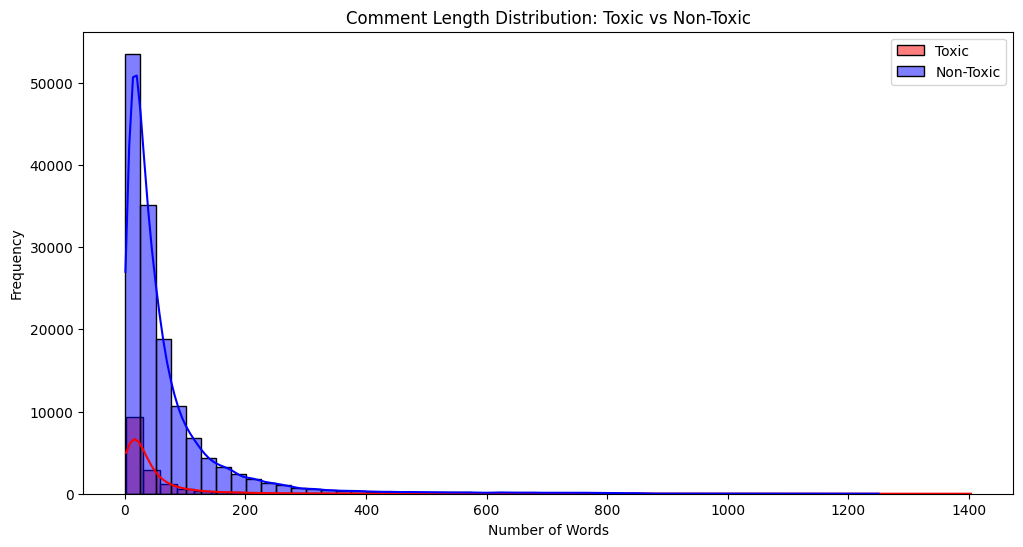

In [ ]:
# Cell 11: Comment Length Distribution for Toxic vs Non-Toxic
plt.figure(figsize=(12, 6))
sns.histplot(train[train['toxic'] == 1]['comment_length'], color='red', label='Toxic', bins=50, kde=True)
sns.histplot(train[train['toxic'] == 0]['comment_length'], color='blue', label='Non-Toxic', bins=50, kde=True)
plt.legend()
plt.title('Comment Length Distribution: Toxic vs Non-Toxic')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


# Step 2: Model Building

In [ ]:
# Targets
targets = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data, train[targets], test_size=0.2, random_state=42)

# Model architecture
input_layer = Input(shape=(max_seq_length,))
embedding_layer = Embedding(len(tokenizer.word_index) + 1, 128)(input_layer)
lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)
dropout_layer = Dropout(0.5)(lstm_layer)
lstm_layer_2 = LSTM(64)(dropout_layer)

output_layers = [Dense(1, activation='sigmoid', name=target)(lstm_layer_2) for target in targets]

model = Model(inputs=input_layer, outputs=output_layers)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
history = model.fit(X_train, [y_train[target] for target in targets],
                    validation_data=(X_val, [y_val[target] for target in targets]),
                    epochs=5, batch_size=64, callbacks=[checkpoint])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1403)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1403, 128)            3190924   ['input_1[0][0]']             
                                                          8                                       
                                                                                                  
 lstm (LSTM)                 (None, 1403, 128)            131584    ['embedding[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, 1403, 128)            0         ['lstm[0][0]']            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1995/1995 [==============================] - 316s 153ms/step - loss: 0.5220 - toxic_loss: 0.1897 - severe_toxic_loss: 0.0395 - obscene_loss: 0.1135 - threat_loss: 0.0211 - insult_loss: 0.1162 - identity_hate_loss: 0.0420 - toxic_accuracy: 0.9388 - severe_toxic_accuracy: 0.9897 - obscene_accuracy: 0.9649 - threat_accuracy: 0.9965 - insult_accuracy: 0.9628 - identity_hate_accuracy: 0.9910 - val_loss: 0.3161 - val_toxic_loss: 0.1098 - val_severe_toxic_loss: 0.0266 - val_obscene_loss: 0.0588 - val_threat_loss: 0.0126 - val_insult_loss: 0.0740 - val_identity_hate_loss: 0.0343 - val_toxic_accuracy: 0.9629 - val_severe_toxic_accuracy: 0.9899 - val_obscene_accuracy: 0.9773 - val_threat_accuracy: 0.9977 - val_insult_accuracy: 0.9685 - val_identity_hate_accuracy: 0.9908
Epoch 2/5
1995/1995 [==============================] - 255s 128ms/step - loss: 0.2679 - toxic_loss: 0.0870 - severe_toxic_loss: 0.0231 - obscene_loss: 0.0504 - threat_loss: 0.0148 - insult_loss: 0.0628 - identity_hate_loss: 0.029

In [ ]:
model.save('best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Step 3: Generate Predictions and Submission File

In [ ]:
# Load the best model
# model.load_weights('best_model.h5')

# Predict on test data
predictions = model.predict(test_data)

# Create submission file
submission = pd.DataFrame({'id': test['id']})
for i, target in enumerate(targets):
    submission[target] = predictions[i]

# Save submission
submission.to_csv('submission.csv', index=False)


4787/4787 [==============================] - 165s 34ms/step


In [ ]:
pd.read_csv('submission.csv').head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.993002,0.126910,0.968399,0.074681,0.900927,0.123221
1,0000247867823ef7,0.000113,0.000002,0.000031,0.000005,0.000010,0.000006
2,00013b17ad220c46,0.004142,0.000022,0.000417,0.000160,0.000398,0.000112
3,00017563c3f7919a,0.000095,0.000002,0.000028,0.000005,0.000010,0.000006
4,00017695ad8997eb,0.000235,0.000003,0.000051,0.000009,0.000022,0.000010
